## FeatureSelection
**time  : 2019/12/24**  
**author: mjl**  
**paper : A Feature Selection Layer Integrated Within A Deep Learning Framework**  

这是该论文中提到的一种特征选择的计算方法， 和CancelOut原理相同。
我们知道正则化会惩罚参数， 而$L_{1}$正则化很容易产生系数矩阵， 使得参数为0或接近于0
。对于FeatureSelection， 其正是通过使用$L_{1}$正则化来惩罚各个特征对应的参数， 从而去选择特征。  
![fs.png](./img/fs.png)

## import

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

session = tf.Session(config=config)

## FS

In [19]:
class FSLayer(object):
    def __init__(self, input, dims, **kwargs):
        self.input = input
        self.weights = tf.Variable(tf.truncated_normal([1, dims], stddev=0.1))
        
    def feature_selection(self):
        return self.input * self.weights
    
    def layer_weights(self):
        return self.weights

## 加载数据

In [20]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

scaler = StandardScaler()
X1 = scaler.fit_transform(load_breast_cancer()['data'])
Y1 = load_breast_cancer()['target'].reshape([-1, 1])
print(X1.shape)
print(Y1.shape)

(569, 30)
(569, 1)


## 建立网络

In [23]:
def build_fs_Net(x, y, batch_size=100, num_epochs = 100):
    xs = tf.placeholder(tf.float32, [None, x.shape[1]])
    ys = tf.placeholder(tf.float32, [None, y.shape[1]])
    
    fs = FSLayer(xs, x.shape[1])
    temp = fs.feature_selection()
    temp = tf.layers.dense(temp, x.shape[1] + 10, activation=tf.nn.relu)
    temp = tf.layers.dense(temp, 2)
    
    ## L1正则化
    l1_norm = tf.contrib.layers.l1_regularizer(0.1/x.shape[1])(fs.layer_weights())
    ## 交叉损失
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.argmax(ys, axis=1), logits=temp)
    ## 总损失
    loss = tf.reduce_mean(cross_entropy) + l1_norm
    
    train_op = tf.train.AdamOptimizer(learning_rate=0.005).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        list_loss = []
        for i in range(num_epochs):
            nums = int(x.shape[0] / batch_size)
            for j in range(nums):
                tempx = x[j*batch_size : (j+1)*batch_size]
                tempy = y[j*batch_size : (j+1)*batch_size]
                
                sess.run(train_op, feed_dict={xs:tempx , ys:tempy })
                if j == nums-1:
                    list_loss.append(sess.run(loss, feed_dict={xs:tempx , ys:tempy }))
        w = sess.run(fs.layer_weights())
        plt.plot(list_loss)
        plt.show()
        return w
    

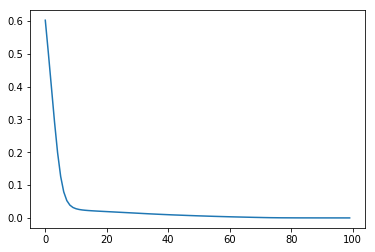

In [24]:
tf.reset_default_graph()
layer_weights = build_fs_Net(X1, Y1)

In [26]:
# print(np.argsort(layer_weights, axis=1))
print(np.argsort(layer_weights, axis=1)[0])

[ 3 11 12 26 21  9  2  7  6 25 22 15 27 10  5 17 16  1  0 19 18 20 29 14 13
 23  4 24 28  8]
